In [1]:
! pip install pandas

In [8]:
pwd

'/content'

In [1]:
!nvidia-smi

Mon Mar 21 08:44:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# 跟google drive連結
from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# mnist
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

In [3]:
# GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU State:', device)

GPU State: cuda:0


In [ ]:
# 存模型參數
# PATH = './cifar_net.pth'
# torch.save(net.state_dict(), PATH) 

In [ ]:
# 讀模型參數 (讀回來)
# net = Net().to(device)
# net.load_state_dict(torch.load(PATH)) # 用這種

## EMNIST

baseline 準確率 = 81% or up

Model Improvement 要比baseline up

In [4]:
# Transform
# 圖片進來時是值為[0~255]之間(黑白)，經過ToTensor後(就是每一個像素除以255)值就變為[0~1]之間,normalize後是[-1,1]之間
# rotate 是將原圖轉-90度 而 hflip 是將圖片垂直鏡像翻轉
transform = transforms.Compose(
    [lambda img : transforms.functional.rotate(img,-90),
     lambda img : transforms.functional.hflip(img),
     transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

# Data
trainSet = torchvision.datasets.EMNIST(root="data/", split="byclass", download=True, train=True, transform=transform)              
testSet = torchvision.datasets.EMNIST(root="data/", split="byclass", download=True, train=False, transform=transform)
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=64, shuffle=True)
testLoader = torch.utils.data.DataLoader(testSet, batch_size=64, shuffle=False)

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting data/EMNIST/raw/gzip.zip to data/EMNIST/raw


In [5]:
trainSet

Dataset EMNIST
    Number of datapoints: 697932
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               <function <lambda> at 0x7f911eb85560>
               <function <lambda> at 0x7f911eb85320>
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [6]:
testSet

Dataset EMNIST
    Number of datapoints: 116323
    Root location: data/
    Split: Test
    StandardTransform
Transform: Compose(
               <function <lambda> at 0x7f911eb85560>
               <function <lambda> at 0x7f911eb85320>
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [7]:
print("Total No of Images in EMNIST dataset:", len(trainSet) + len(testSet))
print("No of images in Training dataset:    ",len(trainSet))
print("No of images in Testing dataset:     ",len(testSet))
l = trainSet.classes
l.sort()
print("No of classes: ",len(l))
print("List of all classes")
print(l)
classes=l

Total No of Images in EMNIST dataset: 814255
No of images in Training dataset:     697932
No of images in Testing dataset:      116323
No of classes:  62
List of all classes
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


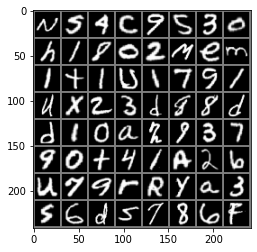

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
for i, data in enumerate(trainLoader, 1):
  images, labels = data
  break

# show images
imshow(torchvision.utils.make_grid(images))

In [9]:
print(images.shape)

torch.Size([64, 1, 28, 28])


In [10]:
import torch.nn as nn
import torch.nn.functional as F
# Model
#進來的圖片是(4,3,32,32) batchsize,rgb,height,width
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784,500)
        # self.fc2 = nn.Linear(500,350)
        self.fc2 = nn.Linear(500,200)
        self.dropout1 = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(200,100)
        self.dropout2 = nn.Dropout(p=0.2)
        self.fc4 = nn.Linear(100,62)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = F.relu(self.fc2(x))
        x = self.dropout1(x)
        x = F.relu(self.fc3(x))
        x = self.dropout2(x)
        x = F.leaky_relu(self.fc4(x))
        return x


net = Net().to(device)
print(net)

tensor_dict = net.state_dict()
tensor_list = list(tensor_dict.items())
print('\nModel Parameters:')
for layer_tensor_name, tensor in tensor_list:
    print('Layer {}: {} elements'.format(layer_tensor_name, torch.numel(tensor)))

Net(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=200, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=200, out_features=100, bias=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=100, out_features=62, bias=True)
)

Model Parameters:
Layer fc1.weight: 392000 elements
Layer fc1.bias: 500 elements
Layer fc2.weight: 100000 elements
Layer fc2.bias: 200 elements
Layer fc3.weight: 20000 elements
Layer fc3.bias: 100 elements
Layer fc4.weight: 6200 elements
Layer fc4.bias: 62 elements


In [11]:
# Parameters
import torch.optim as optim
x = []
y = []
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001) # learning_rate = 0.001


In [12]:
for epoch in range(5):  # loop over the dataset multiple times
    x.append(epoch)
    running_loss = 0.0
    for i, data in enumerate(trainLoader, 1):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        inputs = inputs.view(inputs.shape[0], -1)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 5000 == 4999:    # print every 5000 batch
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 5000))
            y.append(running_loss / 5000)
            running_loss = 0.0
            
print('Finished Training')

[1,  5000] loss: 0.945
[1, 10000] loss: 0.653
[2,  5000] loss: 0.604
[2, 10000] loss: 0.589
[3,  5000] loss: 0.570
[3, 10000] loss: 0.567
[4,  5000] loss: 0.549
[4, 10000] loss: 0.555
[5,  5000] loss: 0.542
[5, 10000] loss: 0.547
Finished Training


In [13]:
PATH = './cifar_net_baseline.pth'
torch.save(net.state_dict(), PATH) 

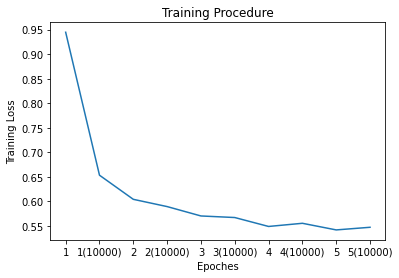

In [13]:
import matplotlib.pyplot as plt
x=np.array([1,2,3,4,5,6,7,8,9,10])
plt.xlabel('Epoches')
plt.ylabel('Training Loss')
plt.title('Training Procedure')
plt.xticks(x, ['1', '1(10000)','2', '2(10000)','3', '3(10000)','4', '4(10000)','5', '5(10000)'])

plt.plot(x,y)
plt.show()


# x = np.array([0,1,2,3])
# y = np.array([20,21,22,23])
# my_xticks = ['John','Arnold','Mavis','Matt']
# plt.xticks(x, my_xticks)
# plt.plot(x, y)
# plt.show()

In [14]:
# Test
correct = 0
total = 0
class_correct = [0 for i in range(62)]
class_total = [0 for i in range(62)]

for i, data in enumerate(testLoader, 1):
    with torch.no_grad():
      inputs, labels = data[0].to(device), data[1].to(device)
      inputs = inputs.view(inputs.shape[0], -1)
      outputs = net(inputs)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      c = (predicted == labels)
      for i in range(len(labels)):
        label = labels[i]
        class_correct[label] += c[i].item()
        class_total[label] += 1
        # print(class_correct)
        # print(class_total)

print('Accuracy of the network on the 10000 test images: %d %%' % (100*correct / total))

for i in range(62):
    print('Accuracy of %d: %3f' % (i, (class_correct[i]/class_total[i])))

Accuracy of the network on the 10000 test images: 81 %
Accuracy of 0: 0.706300
Accuracy of 1: 0.969826
Accuracy of 2: 0.947691
Accuracy of 3: 0.966158
Accuracy of 4: 0.950703
Accuracy of 5: 0.860694
Accuracy of 6: 0.962664
Accuracy of 7: 0.988760
Accuracy of 8: 0.947097
Accuracy of 9: 0.957615
Accuracy of 10: 0.914313
Accuracy of 11: 0.804012
Accuracy of 12: 0.901668
Accuracy of 13: 0.706033
Accuracy of 14: 0.873090
Accuracy of 15: 0.854167
Accuracy of 16: 0.686801
Accuracy of 17: 0.867562
Accuracy of 18: 0.298828
Accuracy of 19: 0.840256
Accuracy of 20: 0.719895
Accuracy of 21: 0.872840
Accuracy of 22: 0.924579
Accuracy of 23: 0.900814
Accuracy of 24: 0.633782
Accuracy of 25: 0.902649
Accuracy of 26: 0.784504
Accuracy of 27: 0.799753
Accuracy of 28: 0.884835
Accuracy of 29: 0.863579
Accuracy of 30: 0.912587
Accuracy of 31: 0.616834
Accuracy of 32: 0.720844
Accuracy of 33: 0.719907
Accuracy of 34: 0.644110
Accuracy of 35: 0.433190
Accuracy of 36: 0.794404
Accuracy of 37: 0.709261
Accur

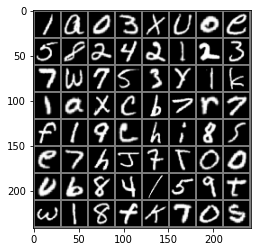

    1,    a,    0,    3,    X,    U,    O,    e,    5,    8,    2,    4,    2,    1,    2,    3,    7,    W,    7,    5,    3,    Y,    1,    k,    I,    a,    x,    C,    b,    7,    r,    7,    F,    1,    9,    C,    h,    i,    8,    5,    e,    7,    h,    J,    7,    T,    0,    0,    U,    6,    8,    4,    1,    5,    9,    t,    w,    1,    8,    F,    k,    7,    0,    S


In [15]:
for i, data in enumerate(testLoader, 1):
  with torch.no_grad():
    images, labels = data
    inputs, labels = data[0].to(device), data[1].to(device)
    inputs = inputs.view(inputs.shape[0], -1)
    outputs = net(inputs)
    _, predicted = torch.max(outputs, 1)
    break

# show images
imshow(torchvision.utils.make_grid(images))
print(','.join('%5s' % classes[j] for j in predicted.cpu().numpy()))



torch.Size([1, 28, 28])


In [16]:
from sklearn.metrics import confusion_matrix 

confusion_matrix = torch.zeros(len(classes), len(classes))

for i, (datas, labels) in enumerate(testLoader, 1):

  inputs = datas.to(device)
  labels = labels.to(device)
  inputs = inputs.view(inputs.shape[0], -1)
  outputs = net(inputs)

  _, preds = torch.max(outputs, 1)
  for t, p in zip(labels.view(-1), preds.view(-1)):
      # print(t, p)
      confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
print(confusion_matrix.diag()/confusion_matrix.sum(1))



tensor([[4.0510e+03, 3.0000e+00, 4.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0000e+00, 6.1250e+03, 4.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 4.0000e+00, 5.5820e+03,  ..., 1.0000e+00, 0.0000e+00,
         5.4000e+01],
        ...,
        [0.0000e+00, 1.0000e+00, 3.0000e+00,  ..., 2.0600e+02, 1.0000e+00,
         5.0000e+00],
        [0.0000e+00, 4.0000e+00, 1.0000e+00,  ..., 2.0000e+00, 2.8000e+01,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.4600e+02,  ..., 1.0000e+00, 0.0000e+00,
         1.6400e+02]])
tensor([0.7011, 0.9676, 0.9511, 0.9662, 0.9503, 0.8572, 0.9604, 0.9881, 0.9448,
        0.9604, 0.8992, 0.8040, 0.8965, 0.7240, 0.8837, 0.8361, 0.7002, 0.8426,
        0.2959, 0.8387, 0.6963, 0.8852, 0.9226, 0.9016, 0.6345, 0.9062, 0.7797,
        0.7960, 0.8883, 0.8591, 0.9016, 0.6382, 0.7667, 0.7292, 0.6479, 0.4440,
        0.7798, 0.6987, 0.0347, 0.9168, 0.9516, 0.1700, 0.2241, 0.8749, 0.3068,
    

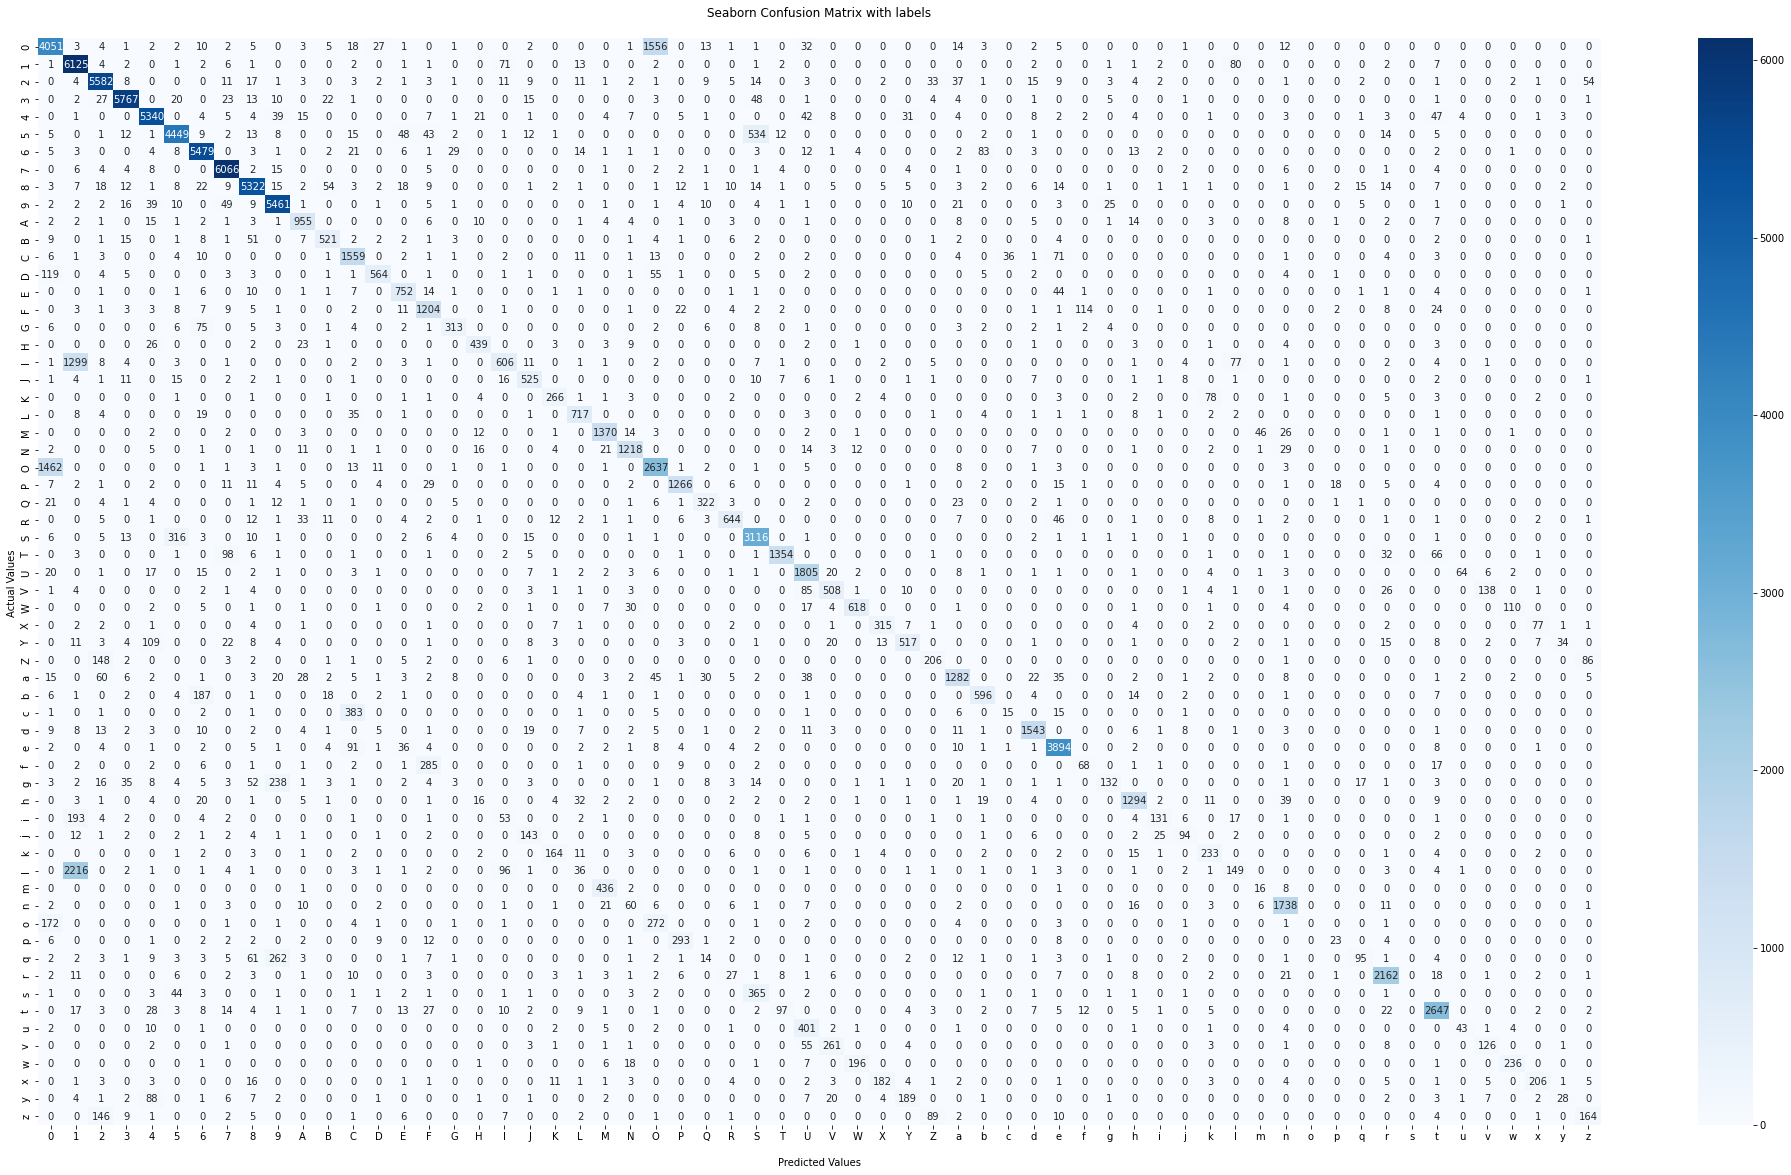

In [17]:
import pandas as pd
import seaborn as sns

plt.figure(figsize = (35,20))

ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_title('Seaborn Confusion Matrix with labels\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)

## Display the visualization of the Confusion Matrix.

plt.show()
# plt.savfig("Evoone_DL2")

In [ ]:
# 配合講者HW2 投影片的P11 要注意的地方
# net.train(True) 
# for i, data in enumerate(trainLoader, 1):



# net.train(False)
# for i, data in enumerate(testLoader, 1):
#   with torch.no_grad():

# net.train(?) ? = True or False
# 主要用於通知dropout層和batchnorm層在train和val模式間切換
# 在train模式下，dropout網絡層會按照設定的參數p設置保留激活單元的機率（保留機率=p); batchnorm層會繼續計算數據的mean和var等參數並更新。
# 在val模式下，dropout層會讓所有的激活單元都通過，而batchnorm層會停止計算和更新mean和var，直接使用在訓練階段已經學出的mean和var值。
# 該模式不會影響各層的gradient計算行為，即gradient計算和存儲與training模式一樣，只是不進行反傳（backprobagation）
# 而with torch.no_grad()則主要是用於停止autograd模塊的工作，以起到加速和節省顯存的作用，具體行為就是停止gradient計算，從而節省了GPU算力和顯存，但是並不會影響dropout和batchnorm層的行為。